# Importing Libraries

In [57]:
import pandas as pd
import numpy as np
import matplotlib as pt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.display import display, HTML

# Importing and Transforming Scraped Data

In [36]:
#Reading in scraped data
raw_data = pd.read_csv('mydealz_data.csv',skipinitialspace=True)

#creating new feature local_deal
local_deal = raw_data['publication_date'].str.find('lokal')
raw_data['local_deal'] = np.where(local_deal != -1,True,False)

#removing characters from title column
raw_data['title'].replace(to_replace='\n\t',value='',regex=True,inplace=True)

#removing characters from temp1, temp 2, temp 3 column
raw_data[['temp1','temp2','temp3']] = raw_data[['temp1','temp2','temp3']].replace(to_replace=['\n\t\t','°\n\t','°'],value=['','',''],regex=True)

#combining temp1, temp2 and temp3 to one column
raw_data['temperature'] = raw_data['temp1'].fillna(raw_data['temp2']).fillna(raw_data['temp3'])

#dropping other temp labels afterwards
raw_data.drop(labels=['temp1','temp2','temp3'],axis=1)

#changing data type to numeric
raw_data['temperature'] = pd.to_numeric(raw_data['temperature'])

#removing characters from old_price and new_price
raw_data[['old_price','new_price']] = raw_data[['old_price','new_price']].replace(to_replace={'€':''},regex=True)
raw_data['old_price'] = raw_data['old_price'].str.replace('.','').str.replace(',','.')
raw_data['new_price'] = raw_data['new_price'].str.replace('.','').str.replace(',','.').str.replace('KOSTENLOS','0')
raw_data['old_price'] = pd.to_numeric(raw_data['old_price'])
raw_data['new_price'] = pd.to_numeric(raw_data['new_price'])

#calculating discount
raw_data['discount'] = (raw_data['old_price']- raw_data['new_price'])/raw_data['old_price']

#removing characters from deal link
raw_data['deal_link'] = raw_data['deal_link'].str.replace('http://twitter.com/intent/tweet\?url=','',1)
raw_data['deal_link'] = raw_data['deal_link'].str.split('&text').str[0]

#removing characters from description
raw_data['description'].replace(to_replace=['\t\t\t','\n'],value=['',''],regex=True,inplace=True)

#transforming date
abbreviation_dictionary = {
        ' Jan':'01',
        ' Feb':'02',
        ' Mär':'03',
        ' Apr':'04',
        ' Mai':'05',
        ' Jun':'06',
        ' Jul':'07',
        ' Aug':'08',
        ' Sep':'09',
        ' Okt':'10',
        ' Nov':'11',
        ' Dez':'12',
    }   

def transform_date(x):
    if x.find('eingestellt vor') != -1:
        return '9.12.2018'
    elif x.find('aktualisiert') != -1:
        x = x[x.find('eingestellt')+12:x.find(')')]
        if len(x) <= 7:
            for month,number in abbreviation_dictionary.items():
                x = x.replace(month,number+'.2018')
            return x
        else: 
            for month,number in abbreviation_dictionary.items():
                x = x.replace(month,number+'.')
            return x
    elif x.find('eingestellt') != -1:
        x = x[x.find('eingestellt')+15:]
        if len(x) <= 7:
            for month,number in abbreviation_dictionary.items():
                x = x.replace(month,number+'.2018')
            return x
        else: 
            for month,number in abbreviation_dictionary.items():
                x = x.replace(month,number+'.')
            return x
    else:
        return x

raw_data['publication_date'] = raw_data['publication_date'].apply(transform_date)
raw_data['publication_date'] = raw_data['publication_date'].replace(' ','',regex= True)
raw_data['publication_date'] = pd.to_datetime(raw_data['publication_date'])

#encoding local deal
def encoding(x):
    if x == True:
        return 1
    elif x == False:
        return 0

raw_data['local_deal'] = mydealz_data['local_deal'].apply(encoding)

#creating final data frame
mydealz_data = raw_data[['title','temperature','old_price','new_price','discount','username', 'number_of_comments','local_deal','description','publication_date','deal_link',]]

#mydealz_data.to_csv('mydealz_final_dataset.csv')

# Data Analysis

## General Overview

In [4]:
mydealz_data.describe()

,temperature,old_price,new_price,discount,number_of_comments,local_deal
count,63415.000000,40862.000000,54968.000000,40862.000000,63415.000000,63415.000000
mean,532.942884,241.857068,223.439065,0.311186,37.782007,0.123851
std,694.053675,785.683735,1150.348417,0.203570,166.211209,0.329414
min,0.000000,0.080000,-920.000000,0.000058,0.000000,0.000000
25%,236.000000,21.950000,11.420000,0.166290,8.000000,0.000000
50%,337.000000,63.795000,39.980000,0.256413,16.000000,0.000000
75%,526.000000,219.900000,169.520000,0.400473,33.000000,0.000000
max,22386.000000,60000.000000,151080.000000,1.000000,22733.000000,1.000000


In [6]:
mydealz_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63415 entries, 0 to 63414
Data columns (total 11 columns):
title                 63415 non-null object
temperature           63415 non-null int64
old_price             40862 non-null float64
new_price             54968 non-null float64
discount              40862 non-null float64
username              63415 non-null object
number_of_comments    63415 non-null int64
local_deal            63415 non-null bool
description           63389 non-null object
publication_date      63415 non-null datetime64[ns]
deal_link             63415 non-null object
dtypes: bool(1), datetime64[ns](1), float64(3), int64(2), object(4)
memory usage: 4.9+ MB


## Explanatory Data Analysis

In [9]:
#Increasing column width for readability
pd.set_option('display.max_colwidth',1000)

What where the top 3 hottest overall deals on MyDealz?

In [10]:
mydealz_data.sort_values(by='temperature',ascending=False).head(3)[['title','temperature','deal_link','description','publication_date']]

,title,temperature,deal_link,description,publication_date
28810,19%-MwSt-geschenkt-Aktion am 21. und 22.09.2018 bei Media Markt und Saturn on- und offline,22386,https://www.mydealz.de/deals/19-mwst-geschenkt-aktion-am-21-und-22092018-bei-media-markt-und-saturn-on-und-offline-1230945,"Bei Media Markt startet am 21 und 22.09.2018 wieder eine 19% MwSt geschenkt Aktion auf alle Artikel . Z.b wird es den GQ65Q9FNG statt für 3059€ für 2477,79€. Das beste Angebot ist bei idealo mit 2639€ also spart über 160€",2018-07-09
51320,10€ Rabatt ohne MBW (unbegrenzt oft) auf alles bei Amazon durch Spiele-Gutscheinfehler,18021,https://www.mydealz.de/deals/10eur-rabatt-ohne-mbw-unbegrenzt-oft-auf-alles-bei-amazon-durch-spiele-gutscheinfehler-1126286,"Auch auf die Gefahr hin, dass nun alles was ich bestellt habe gecancelled wird, hier ein grandioser Deal:Legt ein Spiel bei Amazon in den Einkaufswagen (wichtig, dass es kein Marketplacehändler, sondern Amazon selber ist) und geht zur Kasse.Es werden dann 10€ abgezogen.Ihr könnt jetzt einfach noch ein anderes Produkt in den Warenkorb legen (einzige Bedingung: ""Verkauf und Versand durch Amazon"") und das Spiel dann an der Kasse (also im letzten Bestellschritt) wieder entfernen. Die 10€ Rabatt bleiben bestehen!Somit extrem viele Freebies möglich.Funktioniert sooft man möchte.Auf zwei Accounts getestet.",2018-07-02
57519,Geleakte Mediamarkt Geschenkkarten Aktion 2016 [20.12. - 21.12.],17746,https://www.mydealz.de/deals/geleakte-mediamarkt-geschenkkarten-aktion-2016-2012-2112-903656,"Ursprünglicher Deal vom 12.12.2016Bisher wurde die Aktion noch nicht veröffentlicht, jedoch sieht es so aus als würde es dieses Jahr wieder eine Geschenkkarten Aktion geben indem man 50€ für eine 60€ Geschenkkarte bei Mediamarkt bezahlt. Falls es stimmen sollte denke ich mega hot",2016-12-12


What were the top 10 hottest deals in 2018?

In [11]:
mydealz_data[(mydealz_data['publication_date'] > '01.01.2018') & (mydealz_data['publication_date'] < '31.12.2018')].sort_values(by='temperature',ascending=False).head(10)

,title,temperature,old_price,new_price,discount,username,number_of_comments,local_deal,description,publication_date,deal_link
28810,19%-MwSt-geschenkt-Aktion am 21. und 22.09.2018 bei Media Markt und Saturn on- und offline,22386,NaN,NaN,NaN,Redsoldier,6491,False,"Bei Media Markt startet am 21 und 22.09.2018 wieder eine 19% MwSt geschenkt Aktion auf alle Artikel . Z.b wird es den GQ65Q9FNG statt für 3059€ für 2477,79€. Das beste Angebot ist bei idealo mit 2639€ also spart über 160€",2018-07-09,https://www.mydealz.de/deals/19-mwst-geschenkt-aktion-am-21-und-22092018-bei-media-markt-und-saturn-on-und-offline-1230945
51320,10€ Rabatt ohne MBW (unbegrenzt oft) auf alles bei Amazon durch Spiele-Gutscheinfehler,18021,NaN,NaN,NaN,philippmb,12770,False,"Auch auf die Gefahr hin, dass nun alles was ich bestellt habe gecancelled wird, hier ein grandioser Deal:Legt ein Spiel bei Amazon in den Einkaufswagen (wichtig, dass es kein Marketplacehändler, sondern Amazon selber ist) und geht zur Kasse.Es werden dann 10€ abgezogen.Ihr könnt jetzt einfach noch ein anderes Produkt in den Warenkorb legen (einzige Bedingung: ""Verkauf und Versand durch Amazon"") und das Spiel dann an der Kasse (also im letzten Bestellschritt) wieder entfernen. Die 10€ Rabatt bleiben bestehen!Somit extrem viele Freebies möglich.Funktioniert sooft man möchte.Auf zwei Accounts getestet.",2018-07-02,https://www.mydealz.de/deals/10eur-rabatt-ohne-mbw-unbegrenzt-oft-auf-alles-bei-amazon-durch-spiele-gutscheinfehler-1126286
46065,"[REWE] 10% z.B. auf Amazon/MediaMarkt/Saturn Guthaben durch deingutschein, 20% auf C&A, Aktion-Mensch extra Los, KITKAT RUBY",16629,NaN,NaN,NaN,lolnickname,5978,False,"Heute ist der letzte Tag!Ab 07.05.2018 bis 12.05.2018 gibt es bei Rewe verschiedene Geschenkkarten reduziert.Die deingutschein Karte ist um 10% reduziert. Diese ist individuell aufladbar von 15 - 150 €. Über diese lässt sich dann z.B. Amazonguthaben bestellen.Außerdem sind C&A Karten um 20% reduziert.Wer ein Aktion–Mensch-Losgutschein kauft erhält auf dem Bon ein zusätzliches Los.Außerdem wird in der Woche das neue KITKAT RUBY im Rewe erhältlich sein.41,5g pro Packung für 1,29€Rewe ist erstmal der einzige Einzelhändler in Deutschland der diese Sorte im Sortiment hat. Quelle",2018-04-24,https://www.mydealz.de/deals/rewe-10-zb-auf-amazonmediamarktsaturn-guthaben-durch-deingutschein-20-auf-ca-aktion-mensch-extra-los-kitkat-ruby-1165005
51556,McDonalds Tages Coupons ab 22.02,15734,NaN,1.00,NaN,Hr._K,2352,False,"Ursprünglicher Deal vom 01.02.2018:Ab dem 22.2 gibt es bei MC Donalds, in ganz Deutschland Tages Coupons, die nur einen Tag Gültigkeit haben. Es beginnt mit Bigmac für 1€ am 1. Tag. Die darauf folgenden Tage seht Ihr im Bild. Die Aktion endet am 25.3. diese Coupons wird es nur in der App geben d.h. Ihr braucht die App!Als kleine ""Goodies"" gibt es an bestimmten Tagen z.b. Socken oder einen Schokohasen.Die Aktion heisst ""Der grosse Oster Countdown"" Ostern= Fastenzeit 14.2-31.3 Na dann viel Spass beim Fasten.",2018-01-02,https://www.mydealz.de/deals/mcdonalds-tages-coupons-ab-2202-1123254
39745,24 McNuggets (4x 6er) bei McDonald's mit 6 Saucen für 3€,14729,NaN,3.00,NaN,makuh,1756,False,"Mit dem Code 522 bekommt ihr am Bestellterminal 24 Nuggets mit 6 Saucen für nur unglaubliche 3€. Hat bei mir nicht in allen Filialen geklappt (da meinte das Terminal Bestellung sei unvollständig).Am besten direkt am Terminal bezahlen. Wo genau der Code herkommt weiß ich auch nicht. Einlösbar ab 10:30, feiertags 11.30",2018-07-18,https://www.mydealz.de/deals/24-mcnuggets-4x-6er-bei-mcdonalds-mit-6-saucen-fur-3eur-1205104
24071,"*LETZTER TAG* Drillisch Megadeal: kein Anschlusspreis auf monatlich kündbare Verträge: winSIM LTE Allnet 1GB für 6,99€, PremiumSIM LTE 2GB für 6,99€, winSIM LTE Allnet 3GB für 7,99€, PremiumSIM LTE 4GB für 9,99€ uvm.",14097,NaN,6.99,NaN,El_Lorenzo,2323,False,"Bei Drillisch kommt hier ein richtiger Knaller reingeflattert. Alle monatlich kündbaren Tarife bei winSIM und PremiumS

In [12]:
mydealz_data[(mydealz_data['publication_date'] > '01.01.2017') & (mydealz_data['publication_date'] < '31.12.2017')].sort_values(by='temperature',ascending=False).head(10)

,title,temperature,old_price,new_price,discount,username,number_of_comments,local_deal,description,publication_date,deal_link
52515,Apple iPhone 6 und neuer - Akku-Tausch bei Apple für 29€,11650,89.00,29.00,0.674157,Evils,1369,False,"Apple hat gerade ein Statement veröffentlicht zu den aktuellen News rund um Apple's Akku/CPU Politik.Für diejenigen unter euch die es noch nicht mitbekommen haben, Apple steht in der Kontroverse da die Geschwindigkeit eurer CPU mit alterndem Akku verlangsamt wird.Um vermutlich die öffentliche Meinung etwas zu lindern, bietet Apple daher ab Ende Januar 2018 an, den Akku eures iPhone 6 oder neuer für 29€ statt bisher 89€ zu tauschen. Hier das Statement:apple.com/iph…ce/Edit: Keine Gewähr ob es 29€ oder 39€ sein werden. Hierzu gibt es bisher keine Aussage. Optimistisch hatte ich 29€ angegeben.Edit3: Edit2 wurde gelöscht, daher hier nochmals: Die 29€ für den Akku Tausch wurden von Apple bestätigt. Siehe apple.com/de/…ce/",2017-12-28,https://www.mydealz.de/deals/apple-iphone-6-und-neuer-akku-tausch-bei-apple-fur-29eur-1105015
55733,"Kindle, Echo und Fire Tablets zum Prime Day im Angebot - z.B. Amazon Echo für 99,99€ // 20% Rabatt auf Warehousedeals & Amazon Basics",9543,NaN,NaN,NaN,El_Lorenzo,1405,False,"Zum Prime Day, der heute um 18 Uhr auf Amazon startet gibt es schon die ersten Preise, wie Mobiflip berichtet: Besonders krass ist natürlich, dass der Echo für unter 100€ angeboten wird... Zuletzt konnte man ihn mit 50€ Gutschein für 130€ kaufen. Der Preis ist echt der Knaller.Amazon Echo:Amazon Echo Dot für 44,99€ statt 59,99€ - 3287 Bewertungen mit 4,2 SternenDas Echo Dot ist ein sprachgesteuertes Gerät (nennt sich Alexa) mit dem man sich die News vorlesen lassen kann, Musik abspielt, Smart Home Geräte wie z.B. Philips Hue Lampen (oder WeMo, Netatmo, Innogy uvm) steuert und über Bluetooth oder Klinke mit Lautsprechern oder einer Anlage verbunden werden kann. Musik kann von Amazon Music, Spotify oder TuneIn abgespielt werden. Das kleine Teil hat einen eingebauten Lautsprecher, der vollkommen ausreicht, um sich ein Hörbuch zum Einschlafen anzuhören oder sich nebenbei im Badezimmer berieseln zu lassen. Wer richtig Power braucht, der holt sich den Echo, welcher aber keinen Klinke-Aus...",2017-10-07,https://www.mydealz.de/deals/kindle-echo-und-fire-tablets-zum-prime-day-im-angebot-zb-amazon-echo-fur-9999eur-20-rabatt-auf-warehousedeals-amazon-basics-1020892
53960,[Wieder verfügbar!] 5 € Bonus Cashback bei 10 € MBW via shoop.de [Aktivierung nur heute bis 24:00 Uhr möglich],9347,NaN,10.00,NaN,Ice_cold,343,False,"Hallo liebe MyDealzerInnen, Update 1: Wieder verfügbar!Shoop hat gerade die Early Bird Aktion im Rahmen des Black Friday reaktiviert!Geht auf die Aktionsseite [Deal-Link], betätigt den roten Button und loggt euch bei eurem Shoop Account ein, um eine Vormerkung iHv 5 € zu bekommen. Anschließend tätigt ihr im Zeitraum von 7 Tagen nach Aktivierung des Bonus einen Einkauf über Shoop mit einem MBW von mind. 10 €. Wartet nicht zu lange, da die Aktion limitiert ist. Eine Aktivierung ist laut dem heruntertickenden Timer nur heute bis 24:00 Uhr möglich.Zur Klarstellung: DIe 5 € gibt es zusätzlich zum normalen Cashback.Bei erfolgreicher Aktivierung bekommt ihr eine Bestätigungsmail und seht die Vormerkung ""Bonuszahlung an User"" im Bereich Aktivitäten -> Einkäufe.Anbei noch der Aktionstext:Hole das Maximum aus dem Black Friday 2017 - mit Cashback von Shoop.deKlicke einfach auf den roten Button, um Deinen Bonus zu aktivieren und tätige danach innerhalb von 7 Tagen eine Bestellung in Höhe von m...",2017-11-20,https://www.mydealz.de/deals/wieder-verfugbar-5-eur-bonus-cashback-bei-10-eur-mbw-via-shoopde-aktivierung-nur-heute-bis-2400-uhr-moglich-1075373
52935,Gratis Pizza für Obdachlose und Hilfebedürfige - Herne HBF - Pizzeria Arena LOKAL,8432,NaN,NaN,NaN,KNaschke,350,True,"Nein Jungs + Mädels, nicht ausnutzen.Nein, kein Usertreffen.Nein, kein Laden stürmen.Die Pizzeria in Herne am HBF gibt an Heiligabend von 1

In [13]:
time_series.groupby('temperature').resample('Y').max()

NameError: name 'time_series' is not defined

In [40]:
mydealz_data.groupby(pd.Grouper(key='publication_date',freq='A')).max()

,title,temperature,old_price,new_price,discount,username,number_of_comments,local_deal,deal_link
publication_date,,,,,,,,,
2010-12-31,"[Aldi SÜD+NORD] WORKZONE Werkzeugsatz, 94-teilig ab 16.12",2074,NaN,499.99,NaN,spock13,168,True,https://www.mydealz.de/deals/zte-blade-orange-san-francisco-playcom-via-borderlinx-1554
2011-12-31,Übersicht:: Aktuelle Bier Angebote der aktuellen KW 48/11 --> z.B. Holsten üfr 7€ oder Bud für 11€,1003,NaN,1038.90,NaN,yxcv,204,True,https://www.mydealz.de/deals/zwei-bourbon-vanille-stangen-fur-99-cent-bei-lidl-am-17-november-52394
2012-12-31,wasserdichte Fahrradtaschen Dynamics (Mainstream) SL 55,3023,NaN,151080.00,NaN,zweene,542,True,https://www.mydealz.de/deals/zwergobstbaume-bei-norma-ab-heute-fur-999-euro-83234
2013-12-31,Ältere Dungeon & Dragon Bücher als PDF (englisch) umsonst,6004,NaN,62178.60,NaN,ɢноѕтΘпе,1613,True,https://www.mydealz.de/deals/zweibruder-salzpumpe-oder-pfefferpumpe-in-geschenkverpackung-nur-444eur-portofrei-190174
2014-12-31,"Ü-Ei / Kinder-Überraschungsei für nur 0,39 Euro bei Penny ab Montag 14 April",5853,NaN,31889.00,NaN,zunami,4212,True,https://www.mydealz.de/deals/zoo-safaripark-stukenbrock-tagesticket-fur-1390eur-statt-2800eur-330390
2015-12-31,"„Probefahrt XXL"" Elektroauto Renault Twizy, ZOE oder Kangoo Z.E. 48 Stunden lang gratis testen",10415,NaN,16500.00,NaN,zzzzdidizzzz,2580,True,https://www.mydealz.de/deals/zwilling-besteck-garnitur-aberdeen-68-teilig-poliert-12999-eur-karstadt-zwilling-treue-aktion-70eur-rabatt-472961
2016-12-31,"zusätzlich 50% reduziert; Camel, Calamar, Hattric, Bekleidung und Schuhe im Fabrikverkauf Bültel-Outlet (lokal in Salzbergen bei Rheine)",17746,95.9,29999.00,0.503754,zzpaam,22733,True,https://www.mydealz.de/deals/zwilling-zwilling-100-tlg-besteckset-king-fur-12510eur-statt-196eur-742291
2017-12-31,​OppoSuits ​Herren-​​​Weihnachtsanzüge,12055,25390.0,28594.06,1.000000,Ελλας,8453,True,https://www.mydealz.de/deals/zwischen-15-18-jahren-young-and-wild-tarif-bei-mcfit-im-studio-fur-990eur-1012930
2018-12-31,￼\n\nadidas Fußball Telstar WM 2018 Top Glider Größe 5 (Replique),22386,60000.0,49990.00,1.000000,Ωmεgα_Montagen,12770,True,https://www.mydealz.de/deals/zyxel-wireless-access-point-mit-dual-band-80211ac-poe-nwa1123-acv2-1276729


In [683]:
# ONLY RUN THIS CELL IF YOU NEED 
# TO DOWNLOAD NLTK AND HAVE CONDA
# WATCH THE VIDEO FOR FULL INSTRUCTIONS ON THIS STEP

# Uncomment the code below and run:


import nltk # Imports the library
nltk.download_shell()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> l
Packages:
  [ ] abc................. Australian Broadcasting Commission 2006
  [ ] alpino.............. Alpino Dutch Treebank
  [ ] averaged_perceptron_tagger Averaged Perceptron Tagger
  [ ] averaged_perceptron_tagger_ru Averaged Perceptron Tagger (Russian)
  [ ] basque_grammars..... Grammars for Basque
  [ ] biocreative_ppi..... BioCreAtIvE (Critical Assessment of Information
                           Extraction Systems in Biology)
  [ ] bllip_wsj_no_aux.... BLLIP Parser: WSJ Model
  [ ] book_grammars....... Grammars from NLTK Book
  [ ] brown............... Brown Corpus
  [ ] brown_tei........... Brown Corpus (TEI XML Version)
  [ ] cess_cat............ CESS-CAT Treebank
  [

In [14]:
import string
from nltk.corpus import stopwords

def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('german')]

In [691]:
mydealz_data['description'].apply(text_process)

TypeError: 'float' object is not iterable

In [693]:
nopunc

['E',
 'i',
 'n',
 'e',
 ' ',
 'P',
 'a',
 'c',
 'k',
 'u',
 'n',
 'g',
 ' ',
 'k',
 'o',
 's',
 't',
 'e',
 't',
 ' ',
 's',
 'o',
 'n',
 's',
 't',
 ' ',
 'm',
 'i',
 'n',
 'd',
 'e',
 's',
 't',
 'e',
 'n',
 's',
 ' ',
 '1',
 '9',
 '9',
 ' ',
 '€',
 ' ',
 'w',
 'e',
 'n',
 'n',
 ' ',
 'n',
 'i',
 'c',
 'h',
 't',
 ' ',
 'n',
 'o',
 'c',
 'h',
 ' ',
 'm',
 'e',
 'h',
 'r',
 'A',
 'n',
 'd',
 'e',
 'r',
 'e',
 ' ',
 'S',
 'o',
 'r',
 't',
 'e',
 'n',
 ' ',
 's',
 'i',
 'n',
 'd',
 ' ',
 'a',
 'u',
 'c',
 'h',
 ' ',
 'i',
 'm',
 ' ',
 'A',
 'n',
 'g',
 'e',
 'b',
 'o',
 't',
 'F',
 'r',
 'u',
 'c',
 'h',
 't',
 'i',
 'g',
 'e',
 ' ',
 'O',
 'r',
 'a',
 'n',
 'g',
 'e',
 'n',
 's',
 't',
 'ü',
 'c',
 'k',
 'c',
 'h',
 'e',
 'n',
 ' ',
 'u',
 'n',
 'd',
 ' ',
 'w',
 'e',
 'i',
 'ß',
 'e',
 ' ',
 'S',
 'c',
 'h',
 'o',
 'k',
 'o',
 'l',
 'a',
 'd',
 'e',
 'E',
 'r',
 'i',
 'n',
 'n',
 'e',
 'r',
 't',
 ' ',
 'a',
 'n',
 ' ',
 'd',
 'a',
 's',
 ' ',
 'C',
 'a',
 'p',
 'r',
 'i',
 'E',
 'i'

In [4]:
import re

In [12]:
from keras.preprocessing.text import text_to_word_sequence

# define the document
text = mydealz_data['description']
# tokenize the document
result = text_to_word_sequence(text)
print(result)

AttributeError: 'Series' object has no attribute 'lower'

# Text Preprocessing

In [16]:
import nltk

In [17]:
nltk.download_shell()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> stopwords
      Package stopwords is already up-to-date!

---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


In [30]:
for description_no, description in enumerate(mydealz_data['description'][0:10]):
    print(description_no,description)
    print('\n')

0 Eine Packung kostet sonst mindestens 1,99 €, wenn nicht noch mehr!Andere Sorten sind auch im Angebot.Fruchtige Orangenstückchen und weiße SchokoladeErinnert an das Capri-Eis aus Kindertagen


1 Moin,bei Amazon bekommt ihr derzeit als Tagesangebot das Philips Hue White and Color Ambiance E14 LED Kerze Doppelpack inkl. Hue Dimmschalter, dimmbar, steuerbar via App, für 75,59€  inkl. Versandkosten.Preisvergleich: 73,99€ (Doppelpack)Preisvergleich: 43,00€ (Einzelne Lampe)Preisvergleich: 19,95€ (Hue Dimmschalter)Mit unseren Hue Erweiterungen können Sie Ihr Hue System nach Belieben erweitern und das Licht-Erlebnis auf weitere Wohnräume ausweiten. Die White und Color Ambiance Erweiterung ist die Premium-Erweiterung mit allen Funktionalitäten, allen Weißtönen und allen Farben, die das Lichtspektrum zu bieten hat, von einem orangefarbenen warmweißen Licht bis hin zu einem bläulichen kühleren Licht, das dem Tageslicht ähnelt. Den beiliegenden Dimmschalter können Sie an der Wand befestigen und w

In [37]:
mydealz_data['title_length'] = mydealz_data['title'].apply(len)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [58]:
import string

In [59]:
mydealz_data['description'][0]

'Eine Packung kostet sonst mindestens 1,99 €, wenn nicht noch mehr!Andere Sorten sind auch im Angebot.Fruchtige Orangenstückchen und weiße SchokoladeErinnert an das Capri-Eis aus Kindertagen'

In [60]:
nopunc = [c for c in mydealz_data['description'][0] if c not in string.punctuation]

In [61]:
nopunc

['E',
 'i',
 'n',
 'e',
 ' ',
 'P',
 'a',
 'c',
 'k',
 'u',
 'n',
 'g',
 ' ',
 'k',
 'o',
 's',
 't',
 'e',
 't',
 ' ',
 's',
 'o',
 'n',
 's',
 't',
 ' ',
 'm',
 'i',
 'n',
 'd',
 'e',
 's',
 't',
 'e',
 'n',
 's',
 ' ',
 '1',
 '9',
 '9',
 ' ',
 '€',
 ' ',
 'w',
 'e',
 'n',
 'n',
 ' ',
 'n',
 'i',
 'c',
 'h',
 't',
 ' ',
 'n',
 'o',
 'c',
 'h',
 ' ',
 'm',
 'e',
 'h',
 'r',
 'A',
 'n',
 'd',
 'e',
 'r',
 'e',
 ' ',
 'S',
 'o',
 'r',
 't',
 'e',
 'n',
 ' ',
 's',
 'i',
 'n',
 'd',
 ' ',
 'a',
 'u',
 'c',
 'h',
 ' ',
 'i',
 'm',
 ' ',
 'A',
 'n',
 'g',
 'e',
 'b',
 'o',
 't',
 'F',
 'r',
 'u',
 'c',
 'h',
 't',
 'i',
 'g',
 'e',
 ' ',
 'O',
 'r',
 'a',
 'n',
 'g',
 'e',
 'n',
 's',
 't',
 'ü',
 'c',
 'k',
 'c',
 'h',
 'e',
 'n',
 ' ',
 'u',
 'n',
 'd',
 ' ',
 'w',
 'e',
 'i',
 'ß',
 'e',
 ' ',
 'S',
 'c',
 'h',
 'o',
 'k',
 'o',
 'l',
 'a',
 'd',
 'e',
 'E',
 'r',
 'i',
 'n',
 'n',
 'e',
 'r',
 't',
 ' ',
 'a',
 'n',
 ' ',
 'd',
 'a',
 's',
 ' ',
 'C',
 'a',
 'p',
 'r',
 'i',
 'E',
 'i'

In [62]:
from nltk.corpus import stopwords

In [63]:
nopunc = ''.join(nopunc)

In [64]:
nopunc.split()

['Eine',
 'Packung',
 'kostet',
 'sonst',
 'mindestens',
 '199',
 '€',
 'wenn',
 'nicht',
 'noch',
 'mehrAndere',
 'Sorten',
 'sind',
 'auch',
 'im',
 'AngebotFruchtige',
 'Orangenstückchen',
 'und',
 'weiße',
 'SchokoladeErinnert',
 'an',
 'das',
 'CapriEis',
 'aus',
 'Kindertagen']

In [65]:
clean_description = [word for word in nopunc.split() if word.lower() not in stopwords.words('german')]

In [66]:
clean_description

['Packung',
 'kostet',
 'mindestens',
 '199',
 '€',
 'mehrAndere',
 'Sorten',
 'AngebotFruchtige',
 'Orangenstückchen',
 'weiße',
 'SchokoladeErinnert',
 'CapriEis',
 'Kindertagen']

In [75]:
def text_process(text):
    """
    1. remove punc
    2. remove stop words
    3. return list of celan text words
    
    """
    
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('german')]

In [76]:
mydealz_data['description'].head(5).apply(text_process)

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            [Packung, kostet, mindestens, 199, €, mehrAndere, Sorten, AngebotFruchtige, Orangenstückchen, weiße, SchokoladeErinnert, CapriEis, Kinderta

In [77]:
from sklearn.feature_extraction.text import CountVectorizer

In [78]:
bow_tranformer = CountVectorizer(analyzer=text_process).fit(mydealz_data['title'])

In [ ]:
print(len(bow_tranformer.vocabulary_))

In [68]:
title4 = mydealz_data['title'][3]

In [69]:
print(title4)

Notebooksbilliger Adventskalender - Benq EW3270ZL, Odys Winbook 14


In [72]:
bow4 = bow_tranformer.transform([title4])

In [75]:
print(bow4.shape)

(1, 85950)


In [76]:
print(bow4)

  (0, 2844)	1
  (0, 18577)	1
  (0, 22748)	1
  (0, 31086)	1
  (0, 54075)	1
  (0, 54607)	1
  (0, 75672)	1


In [83]:
bow_tranformer.get_feature_names()[75672]

'Winbook'

In [74]:
title_bow = bow_tranformer.transform(mydealz_data['title'])

NameError: name 'bow_tranformer' is not defined

In [86]:
print('Shape of Sparse Matrix: ', title_bow.shape)

Shape of Sparse Matrix:  (63415, 85950)


In [87]:
title_bow.nnz

559984

In [72]:
from sklearn.feature_extraction.text import TfidfTransformer

In [73]:
tfidf_transformer = TfidfTransformer().fit(title_bow)

NameError: name 'title_bow' is not defined

In [91]:
tfidf4 = tfidf_transformer.transform(bow4)

In [94]:
print(tfidf4)

  (0, 75672)	0.4348765804357686
  (0, 54607)	0.42087165837996343
  (0, 54075)	0.33075977162121345
  (0, 31086)	0.45613858147570746
  (0, 22748)	0.42087165837996343
  (0, 18577)	0.26601328236635047
  (0, 2844)	0.26151282130056985


In [48]:
tfidf_transformer.idf_[bow_tranformer.vocabulary_['ebay']]

NameError: name 'tfidf_transformer' is not defined

In [103]:
title_tfidf = tfidf_transformer.transform(title_bow)

In [104]:
title_tfidf

<63415x85950 sparse matrix of type '<class 'numpy.float64'>'
	with 559984 stored elements in Compressed Sparse Row format>

In [105]:
from sklearn.naive_bayes import MultinomialNB

# Linear Regreession

MAE: 288.5794455008757
MSE: 271741.7692924544
RMSE: 521.2885662399036


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


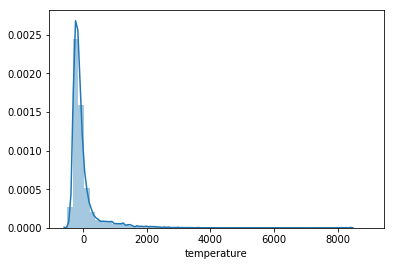

In [59]:
from sklearn.linear_model import LinearRegression

#removing NaN values
no_missing_values = mydealz_data.dropna(axis=0)

#selecting featurees
X = no_missing_values[['old_price','new_price','discount']]
y = no_missing_values['temperature']

#splittting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#creeating model
linear_regression = LinearRegression()
linear_regression.fit(X_train,y_train)
predictions = linear_regression.predict(X_test)

#evaluating model
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

sns.distplot((y_test-predictions),bins=50)
plt.scatter(y_test,predictions)

In [110]:
def temperature_classification(temp):  
        if temp < 100:
            temp = 0
        elif temp < 500:
            temp = 1
            return temp
        elif temp < 1000:
            temp = 2
            return temp
        elif temp < 2000:
            temp = 3
            return temp
        elif temp < 5000:
            temp = 4
            return temp
        elif temp < 10000:
            temp = 5
            return temp
        elif temp < 20000:
            temp = 6
            return temp
        elif temp > 20000:
            temp = 7
            return temp

In [119]:
mydealz_data['temperature_encoded'] = mydealz_data['temperature'].apply(temperature_classification)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [122]:
mydealz_data.groupby('temperature_encoded').count()

,title,temperature,old_price,new_price,discount,username,number_of_comments,local_deal,description,publication_date,deal_link
temperature_encoded,,,,,,,,,,,
1.0,46407,46407,31049,41110,31049,46407,46407,46407,46386,46407,46407
2.0,10212,10212,6244,8585,6244,10212,10212,10212,10208,10212,10212
3.0,4574,4574,2558,3752,2558,4574,4574,4574,4573,4574,4574
4.0,1998,1998,956,1417,956,1998,1998,1998,1998,1998,1998
5.0,189,189,49,90,49,189,189,189,189,189,189
6.0,30,30,6,14,6,30,30,30,30,30,30
7.0,1,1,0,0,0,1,1,1,1,1,1
